In [117]:
%pip install graphviz
%pip install pydot --upgrade
%pip install pydotplus --upgrade

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [118]:
from pathlib import Path
import imghdr
import os

data_dir = "/hair_types"
image_extensions = [".png", ".jpg"] # add there all your images file extensions
img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [119]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "hair_types",
 validation_split=0.1,
 subset="training",
 seed=1337,
 image_size=image_size,
 batch_size=batch_size,
 labels='inferred',
 label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
 "hair_types",
 validation_split=0.1,
 subset="validation",
 seed=1337,
 image_size=image_size,
 batch_size=batch_size,
 labels='inferred',
 label_mode='categorical'
)


Found 987 files belonging to 3 classes.
Using 889 files for training.
Using 889 files for training.
Found 987 files belonging to 3 classes.
Using 98 files for validation.


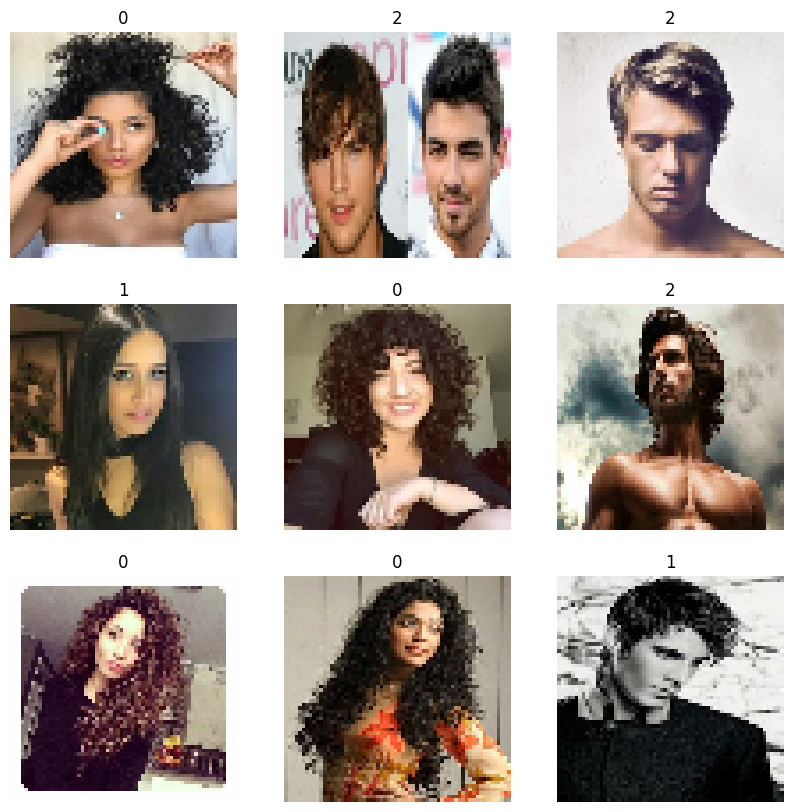

In [120]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
 for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(np.argmax(labels[i])))
    plt.axis("off")
plt.show()

In [121]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from keras.models import Sequential
# from keras.layers import Dense


# model = Sequential()

# model.add(keras.Input(shape=image_size + (3,))) # 64, 64, 3
# model.add(layers.Rescaling(1.0 / 255))
# # model.add(layers.RandomFlip("horizontal"))
# # model.add(layers.RandomRotation(0.1))


# model.add(layers.Conv2D(filters=4, kernel_size=16, strides=1, padding='valid', dilation_rate=1))
# model.add(layers.Activation("relu"))

# model.add(layers.Conv2D(filters=8, kernel_size=8, strides=1, padding='valid', dilation_rate=1))
# model.add(layers.Activation("relu"))

# model.add(layers.Conv2D(filters=16, kernel_size=4, strides=1, padding='valid', dilation_rate=1))
# model.add(layers.Activation("relu"))

# model.add(layers.GlobalAveragePooling2D())
# model.add(layers.Dense(64))
# model.add(layers.Activation("relu"))
# model.add(layers.Dense(3))
# model.add(layers.Activation("softmax"))

# #keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

# epochs = 50

# model.compile(
#  optimizer=keras.optimizers.Adam(1e-3),
#  loss="categorical_crossentropy",
#  metrics=["accuracy"],
# )



In [122]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import Hyperband


# Define the model-building function

def build_model(hp):
    model = keras.Sequential()
    model.add(keras.Input(shape=image_size + (3,)))
    model.add(layers.Rescaling(1.0 / 255))

        # Tune the number of filters and kernel size for each convolutional layer
    for i in range(hp.Int('num_conv_layers', min_value=1, max_value=3)):
        model.add(layers.Conv2D(
            filters=hp.Int('filters_' + str(i), min_value=4, max_value=16, step=4),
            kernel_size=hp.Choice('kernel_size_' + str(i), values=[4, 8, 16]),
            strides=1,
            padding='valid',
            dilation_rate=1,
            kernel_regularizer=keras.regularizers.l2(hp.Choice('l2_reg', values=[1e-2, 1e-3, 1e-4]))
        ))
        model.add(layers.Activation("relu"))
        model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=2))

    # Add more hyperparameters for complexity
    model.add(layers.Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.GlobalAveragePooling2D())

    # Add more layers for complexity
    for _ in range(hp.Int('num_dense_layers', min_value=1, max_value=3)):
        model.add(layers.Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation='relu'
            ))

    model.add(layers.Dense(3, activation='softmax'))

    # Compile the model with the specified learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
     )

    return model


from datetime import datetime
import os

# Get the current date and time
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

# Create a unique project name by appending the current date and time
project_name = f"hair_prediction_{current_time}"

tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    directory='keras_tuner',
    project_name=project_name
)

# Perform the hyperparameter search
tuner.search(train_ds, epochs=50, validation_data=val_ds)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]



Trial 74 Complete [00h 01m 26s]
val_accuracy: 0.5714285969734192

Best val_accuracy So Far: 0.704081654548645
Total elapsed time: 00h 26m 46s


In [123]:
# Assuming 'tuner' is your Keras Tuner object
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Create a table header
print(f"{'Parameter':<25} | {'Value'}")

# Separator for clarity
print("-" * 40)

# Iterate over the hyperparameters and print them
for hp_name in best_hyperparameters.values:
    print(f"{hp_name:<25} | {best_hyperparameters.get(hp_name)}")

Parameter                 | Value
----------------------------------------
num_conv_layers           | 2
filters_0                 | 8
kernel_size_0             | 4
l2_reg                    | 0.0001
dropout                   | 0.1
num_dense_layers          | 1
units                     | 128
learning_rate             | 0.001
filters_1                 | 4
kernel_size_1             | 16
filters_2                 | 16
kernel_size_2             | 4
tuner/epochs              | 50
tuner/initial_epoch       | 17
tuner/bracket             | 1
tuner/round               | 1
tuner/trial_id            | 0064


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5813 - loss: 0.8955 - val_accuracy: 0.6939 - val_loss: 0.8480
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6246 - loss: 0.8357 - val_accuracy: 0.6122 - val_loss: 0.8159
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5922 - loss: 0.8433 - val_accuracy: 0.5102 - val_loss: 0.9001
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5806 - loss: 0.8876 - val_accuracy: 0.6837 - val_loss: 0.8297
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6063 - loss: 0.8506 - val_accuracy: 0.6837 - val_loss: 0.8046
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5946 - loss: 0.8498 - val_accuracy: 0.5408 - val_loss: 0.8551
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6107 - loss: 0.8654 - val_accuracy: 0.5510 - val_loss: 0.8557
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5806 - loss: 0.8736 - val_accuracy: 0.7041 - v

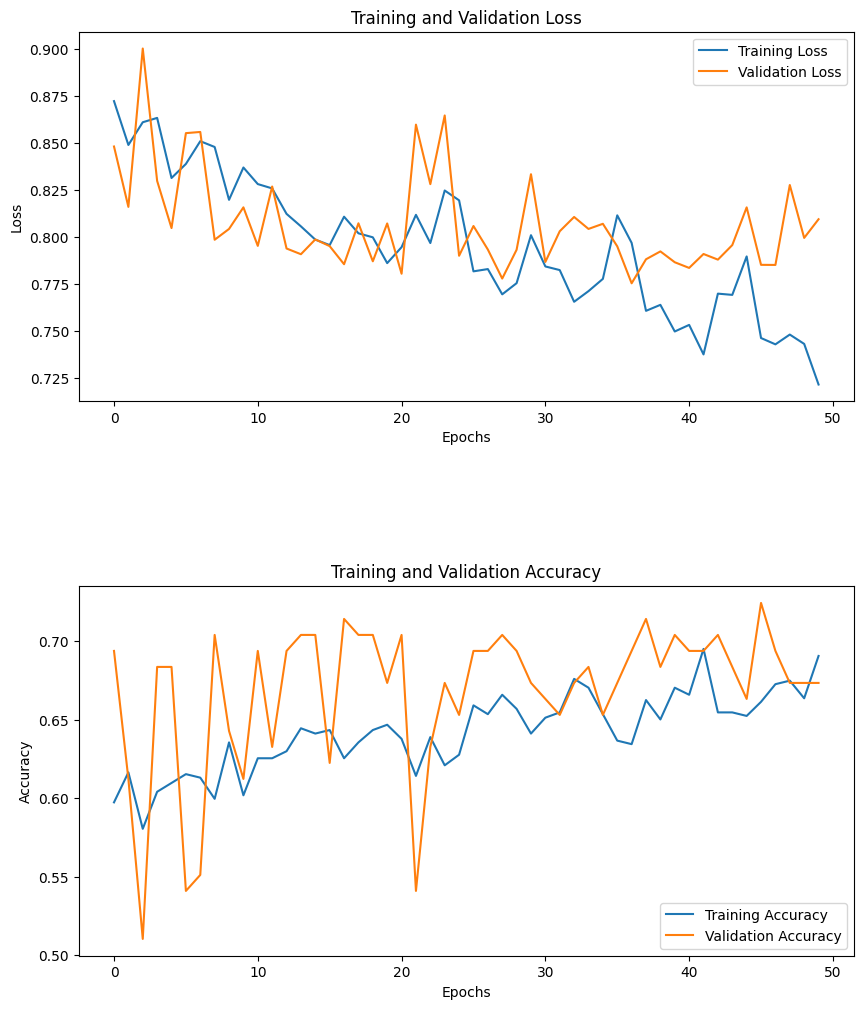

In [124]:
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

epochs = 50
# Assuming train_ds and val_ds are defined and the model is compiled
history = best_model.fit(train_ds, epochs=epochs, validation_data=val_ds)
#history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot the training and validation loss
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# Plot the training and validation accuracy
ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the combined graph
plt.show()




In [127]:

# Evaluate the best model
total_accuracy = 0
total_loss = 0
num_iterations = 10

for _ in range(num_iterations):
    loss, accuracy = best_model.evaluate(val_ds)
    total_accuracy += accuracy
    total_loss += loss


average_accuracy = total_accuracy / num_iterations
average_loss = total_loss / num_iterations
print("Average Accuracy:", average_accuracy)
print("Average Loss:", average_loss)



# Evaluate the best model
total_accuracy = 0
total_loss = 0
num_iterations = 10

for _ in range(num_iterations):
    loss, accuracy = best_model.evaluate(train_ds)
    total_accuracy += accuracy
    total_loss += loss


average_accuracy = total_accuracy / num_iterations
average_loss = total_loss / num_iterations
print("Average Accuracy:", average_accuracy)
print("Average Loss:", average_loss)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6871 - loss: 0.7970  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7079 - loss: 0.7691  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6840 - loss: 0.8189  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6704 - loss: 0.7767  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6954 - loss: 0.7701  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6965 - loss: 0.7461  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6892 - loss: 0.7660  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6527 - loss: 0.8278  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6840 - loss: 0.8023  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6871 - loss: 0.7684  
Average Accuracy: 0.6734693646430969
Average Loss: 0.8093484699726105
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6851 - loss: 0.7296
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6590 - loss: 0.7738
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 

In [126]:
img = keras.preprocessing.image.load_img(
"8126fdb0-ab66-4c49-a85c-f100bc12966a.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis
predictions = best_model.predict(img_array)
print(
 "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavy hair."
 % tuple(predictions[0])
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
This image is 0.74 percent curly hair, 0.15 percent straight hair, and 0.12 percent wavy hair.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
This image is 0.74 percent curly hair, 0.15 percent straight hair, and 0.12 percent wavy hair.
